<a href="https://colab.research.google.com/github/jezgillen/double-descent-experiments/blob/master/Low_data_200_double_descent_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import sys
import os

BACKUP_FOLDER = "drive/My Drive/double_descent_data"


In [ ]:
#!/usr/bin/env python3

# copied some bits from here: https://github.com/milindmalshe/Fully-Connected-Neural-Network-MNIST-Classification-PyTorch/blob/master/FCN_MNIST_Classification_PyTorch.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pickle


class FullyConnected(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes):
        ''' arguments: int, int, list<int> '''
        super().__init__()
        # declare parameters
        self.w = nn.ModuleList() # list of weight matricies

        # this loop initialises all weights except last layer
        for h in hidden_sizes:
            self.w.append(nn.Linear(input_size, h))
            input_size = h

        self.w.append(nn.Linear(input_size, output_size))

    def forward(self, x):
        # define computation
        for w in self.w[:-1]:
            x = F.relu(w(x))

        return self.w[-1](x) # this outputs the logits

    def predict(self, x):
        return F.softmax(self.forward(x))

    def num_parameters(self):
        num_parameters = 0
        for p in self.parameters():
            num_parameters += np.prod(p.shape)
        return num_parameters



# hyperparams

batch_size = 256
num_epochs = 10
lr = 0.01
momentum = 0.9

random_proportion = 0.01

def randomise_labels(labels, fraction):
    num_to_randomise = int(fraction*len(labels))
    torch.manual_seed(0)
    labels[-num_to_randomise:] = torch.randint(0,10,size=(num_to_randomise,))
    return labels


def training_loop(model):

    # get data
    train_dataset = torchvision.datasets.FashionMNIST("./data",train=True, download=True, 
                                                            transform=torchvision.transforms.ToTensor())
    test_dataset = torchvision.datasets.FashionMNIST("./data",train=False, download=True, 
                                                            transform=torchvision.transforms.ToTensor())

    train_subset = torch.utils.data.Subset(train_dataset, range(200))
    print(train_subset)

    # Data loader
    train_loader = torch.utils.data.DataLoader(dataset=train_subset, 
                                               batch_size=batch_size, 
                                               shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                              batch_size=batch_size, 
                                              shuffle=False)


    # set up for training loop
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss_criterion = nn.CrossEntropyLoss()

    print("Num Parameters: ", model.num_parameters())

    curr_loss = 10 #initial values, don't really matter
    prev_loss = 11
    grad_estimate = 0.1 

    # training loop
    epoch = 0
    while(epoch < 360):
        prev_loss = curr_loss
        curr_loss = 0
        num_training_images = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, 28*28)

            # randomise labels
            labels = randomise_labels(labels, random_proportion)

            #  Forward pass
            outputs = model(images)
            loss = loss_criterion(outputs, labels)
            curr_loss += loss.item()*labels.shape[0] #curr batch size
            num_training_images += labels.shape[0]
            
            # Backprpagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #  if (i+1) % 100 == 0:
            #  print ('Epoch [{}/{}], Step [{}], Loss of most recent batch: {:.4f}' 
                       #  .format(epoch+1, num_epochs, i+1, loss.item()))
        curr_loss /= num_training_images
        print(f"Epoch {epoch+1}, Average Loss: {curr_loss}")
        epoch += 1
        grad_estimate = 0.8*grad_estimate + 0.2*(prev_loss-curr_loss)



    # testing

    with torch.no_grad():
        total_correct = 0
        total_loss = 0
        total_images = 0
        for images, labels in train_loader:
            images = images.reshape(-1, 28*28)
            # randomise labels (same way as before)
            labels = randomise_labels(labels, random_proportion)
            outputs = model(images)

            prediction = torch.argmax(outputs, dim=1) # max outputs max and argmax
            num_correct = torch.sum(prediction == labels)
            total_correct += num_correct.item()
            total_images += labels.shape[0]

            total_loss += loss_criterion(outputs, labels).item()*labels.shape[0]

        train_accuracy = total_correct / total_images
        train_loss = total_loss / total_images
        num_training_images = total_images
        print("Train Error: ", 1-train_accuracy)
        print("Train Loss: ", train_loss)

        total_correct = 0
        total_loss = 0
        total_images = 0
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28)
            outputs = model(images)
            

            prediction = torch.argmax(outputs, dim=1) # max outputs max and argmax
            num_correct = torch.sum(prediction == labels)
            total_correct += num_correct.item()
            total_images += labels.shape[0]

            total_loss += loss_criterion(outputs, labels).item()*labels.shape[0]

        gen_accuracy = total_correct / total_images
        gen_loss = total_loss / total_images
        num_test_images = total_images
        
        print("Test Error: ", 1-gen_accuracy)
        print("Test Loss: ", gen_loss)
        print("\n\n")

    stats = dict(num_parameters = model.num_parameters(), 
                 train_accuracy = train_accuracy,
                 train_loss = train_loss,
                 generalisation_accuracy = gen_accuracy,
                 generalisation_loss = gen_loss,
                 num_training_images = num_training_images,
                 num_test_images = num_test_images)
    return stats








In [ ]:
stats_list = []
BACKUP_FOLDER
for i in range(1,25):
    model = FullyConnected(28*28, 10, [i**2, i**2])
    #model.cuda()
    print(model.w[0].weight.device)
    stats = training_loop(model)
    stats_list.append(stats)

    with open(BACKUP_FOLDER+"/stats_backup_1%noise_100_train_v0.pickle", "wb") as f:
        pickle.dump(stats_list, f)

Streaming output truncated to the last 5000 lines.
Epoch 179, Average Loss: 0.26619845628738403
Epoch 180, Average Loss: 0.2628043591976166
Epoch 181, Average Loss: 0.25944632291793823
Epoch 182, Average Loss: 0.2561320960521698
Epoch 183, Average Loss: 0.25285351276397705
Epoch 184, Average Loss: 0.24961024522781372
Epoch 185, Average Loss: 0.24640513956546783
Epoch 186, Average Loss: 0.2432350218296051
Epoch 187, Average Loss: 0.24010445177555084
Epoch 188, Average Loss: 0.2370072603225708
Epoch 189, Average Loss: 0.23394277691841125
Epoch 190, Average Loss: 0.23091350495815277
Epoch 191, Average Loss: 0.22791698575019836
Epoch 192, Average Loss: 0.22495338320732117
Epoch 193, Average Loss: 0.22202613949775696
Epoch 194, Average Loss: 0.21913498640060425
Epoch 195, Average Loss: 0.21627624332904816
Epoch 196, Average Loss: 0.21345071494579315
Epoch 197, Average Loss: 0.21065746247768402
Epoch 198, Average Loss: 0.2078932523727417
Epoch 199, Average Loss: 0.20516495406627655
Epoch 200

In [ ]:
model = FullyConnected(28*28, 10, [500,500])
print(model.w[0].weight.device)
stats = training_loop(model)

cpu


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!
Num Parameters:  648010


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.



Epoch 1, Average Loss: 2.146201294326782
Epoch 2, Average Loss: 1.481806220817566
Epoch 3, Average Loss: 1.2042953722000123
Epoch 4, Average Loss: 1.1042594558715821
Epoch 5, Average Loss: 1.0455188343048096
Epoch 6, Average Loss: 1.000452497959137
Epoch 7, Average Loss: 0.9652989997863769
Epoch 8, Average Loss: 0.938323443031311
Epoch 9, Average Loss: 0.9174315908432007
Epoch 10, Average Loss: 0.9007306803703308
Epoch 11, Average Loss: 0.8868567590236663
Epoch 12, Average Loss: 0.8746196569919586
Epoch 13, Average Loss: 0.8633097458839416
Epoch 14, Average Loss: 0.8528160004615783
Epoch 15, Average Loss: 0.8430315576553344
Epoch 16, Average Loss: 0.8339230914592743
Epoch 17, Average Loss: 0.825256079864502
Epoch 18, Average Loss: 0.817197919511795
Epoch 19, Average Loss: 0.8094353378295899
Epoch 20, Average Loss: 0.8020902487754822
Epoch 21, Average Loss: 0.7949336791038513
Epoch 22, Average Loss: 0.7881446154594421
Epoch 23, Average Loss: 0.7814792113304139
Epoch 24, Average Loss: 0

In [ ]:
torch.cuda.device_count()
torch.cuda.get_device_name(0)

RuntimeError: ignored

In [ ]:
!ls drive/My\ Drive/double_descent_data/
#!cp drive/My\ Drive/double_descent_data/stats_backup3.pickle drive/My\ Drive/double_descent_data/30percentnoise.pickle

10percentnoise.pickle  stats_backup2.pickle
30percentnoise.pickle  stats_backup3.pickle


100 Training examples 1% noise

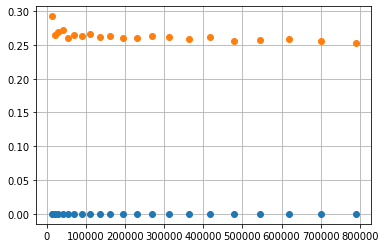

In [ ]:
import matplotlib.pyplot as plt
import pickle
with open(BACKUP_FOLDER+"/stats_backup_1%noise_100_train_v0.pickle", "rb") as f:
    stats_list = pickle.load(f)
stats = stats_list
params = [x['num_parameters'] for x in stats]
#train_loss = [x['train_loss'] for x in stats]
#gen_loss = [x['generalisation_loss'] for x in stats]

train_err = [1-x['train_accuracy'] for x in stats]
gen_err = [1-x['generalisation_accuracy'] for x in stats]

#plt.plot(params, train_loss)
#plt.plot(params, gen_loss)
plt.plot(params[3:], train_err[3:], 'o')
plt.plot(params[3:], gen_err[3:], 'o')
plt.grid()
plt.show()

100 Training examples 30% noise

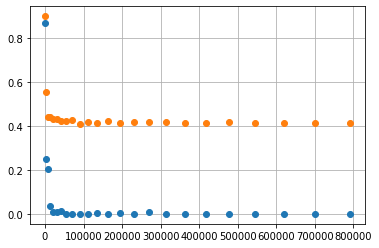

In [ ]:
import matplotlib.pyplot as plt
import pickle
with open(BACKUP_FOLDER+"/stats_backup_100_train_v0.pickle", "rb") as f:
    stats_list = pickle.load(f)
stats = stats_list
params = [x['num_parameters'] for x in stats]
#train_loss = [x['train_loss'] for x in stats]
#gen_loss = [x['generalisation_loss'] for x in stats]

train_err = [1-x['train_accuracy'] for x in stats]
gen_err = [1-x['generalisation_accuracy'] for x in stats]

#plt.plot(params, train_loss)
#plt.plot(params, gen_loss)
plt.plot(params, train_err, 'o')
plt.plot(params, gen_err, 'o')
plt.grid()
plt.show()



## Test vs Train 30% noise 10,000 training examples

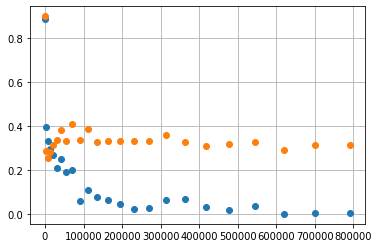

In [ ]:
import matplotlib.pyplot as plt
import pickle
with open(BACKUP_FOLDER+"/30percentnoise.pickle", "rb") as f:
    stats_list = pickle.load(f)
stats = stats_list
params = [x['num_parameters'] for x in stats]
#train_loss = [x['train_loss'] for x in stats]
#gen_loss = [x['generalisation_loss'] for x in stats]

train_err = [1-x['train_accuracy'] for x in stats]
gen_err = [1-x['generalisation_accuracy'] for x in stats]

#plt.plot(params, train_loss)
#plt.plot(params, gen_loss)
plt.plot(params, train_err, 'o')
plt.plot(params, gen_err, 'o')
plt.grid()
plt.show()

## Test vs Train 10% noise fixed

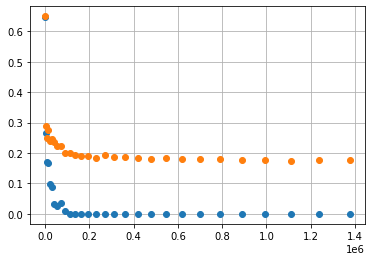

In [ ]:
import matplotlib.pyplot as plt
import pickle
with open(BACKUP_FOLDER+"/stats_backup2.pickle", "rb") as f:
    stats_list = pickle.load(f)
stats = stats_list
params = [x['num_parameters'] for x in stats]
#train_loss = [x['train_loss'] for x in stats]
#gen_loss = [x['generalisation_loss'] for x in stats]

train_err = [1-x['train_accuracy'] for x in stats]
gen_err = [1-x['generalisation_accuracy'] for x in stats]

#plt.plot(params, train_loss)
#plt.plot(params, gen_loss)
plt.plot(params, train_err, 'o')
plt.plot(params, gen_err, 'o')
plt.grid()
plt.show()

# Test vs Train error with 10% label noise

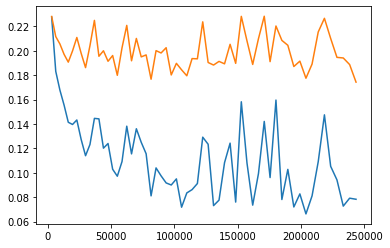

In [ ]:
import matplotlib.pyplot as plt
import pickle
with open(BACKUP_FOLDER+"/10percentnoise.pickle", "rb") as f:
    stats_list = pickle.load(f)
stats = stats_list
params = [x['num_parameters'] for x in stats]
#train_loss = [x['train_loss'] for x in stats]
#gen_loss = [x['generalisation_loss'] for x in stats]

train_err = [1-x['train_accuracy'] for x in stats]
gen_err = [1-x['generalisation_accuracy'] for x in stats]

#plt.plot(params, train_loss)
#plt.plot(params, gen_loss)
plt.plot(params, train_err)
plt.plot(params, gen_err)
plt.show()

In [ ]:
import torchvision
train_dataset = torchvision.datasets.FashionMNIST("./data",train=True, download=True, 
                                                            transform=torchvision.transforms.ToTensor())


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!



/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
train_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 